<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/SHAPEnhanced_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import shap

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Data Preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/RegresiUTSTelkom.csv', low_memory=False)

In [ ]:
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [ ]:
X = df_imputed.iloc[:, 1:]
y = df_imputed.iloc[:, 0]
df_combined = pd.concat([y, X], axis=1)

## Preprocessing

In [ ]:
def remove_outliers_iqr(df, column, multiplier=2.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_clean = remove_outliers_iqr(df_combined, df_combined.columns[0], multiplier=2.0)

In [ ]:
X_for_rf = df_clean.iloc[:, 1:]
y_for_rf = df_clean.iloc[:, 0]

In [ ]:
hgb = HistGradientBoostingRegressor(max_iter=100, random_state=42)
hgb.fit(X_for_rf, y_for_rf)

HistGradientBoostingRegressor(random_state=42)

In [ ]:
explainer = shap.Explainer(hgb)
shap_values = explainer(X_for_rf)

In [ ]:
shap_importances = np.abs(shap_values.values).mean(axis=0)
shap_indices = np.argsort(shap_importances)[::-1]
top_shap_features = X_for_rf.columns[shap_indices[:25]].tolist()

### Using Corelation

In [ ]:
corr = df_clean.corr()
target_corr = corr.iloc[1:, 0].abs().sort_values(ascending=False)
top_corr_features = target_corr.head(10).index.tolist()

In [ ]:
final_features = list(set(top_shap_features + top_corr_features))
X_selected = df_clean[final_features]
y_selected = df_clean.iloc[:, 0]

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_selected), columns=final_features)

## Modeling data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_selected, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(32),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=Huber(), metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1948.9899 - mae: 1949.4285 - val_loss: 1609.8361 - val_mae: 1610.2626 - learning_rate: 5.0000e-04
Epoch 2/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 1406.3523 - mae: 1406.7729 - val_loss: 699.8853 - val_mae: 700.2924 - learning_rate: 5.0000e-04
Epoch 3/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 415.5137 - mae: 415.9180 - val_loss: 15.8856 - val_mae: 16.2799 - learning_rate: 5.0000e-04
Epoch 4/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 39.2960 - mae: 39.6911 - val_loss: 11.1495 - val_mae: 11.5314 - learning_rate: 5.0000e-04
Epoch 5/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 31.4072 - mae: 31.7897 - val_loss: 9.1579 - val_mae: 9.5208 - learning_rate: 5.0000e-04
Epoch 6/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - loss: 24.4229 - mae: 24.7912 - val_loss: 8.8565 - val_mae: 9.2091 - learning_rate: 5.0000e-04
Epoch 7/100
4997/4997 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 

In [ ]:
y_pred = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Refactored Model Evaluation ===")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f} ({r2*100:.2f}%)")

3123/3123 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

=== Refactored Model Evaluation ===
MSE: 55.606055
RMSE: 7.456947
MAE: 5.163008
R²: 0.304156 (30.42%)


## Evaluation

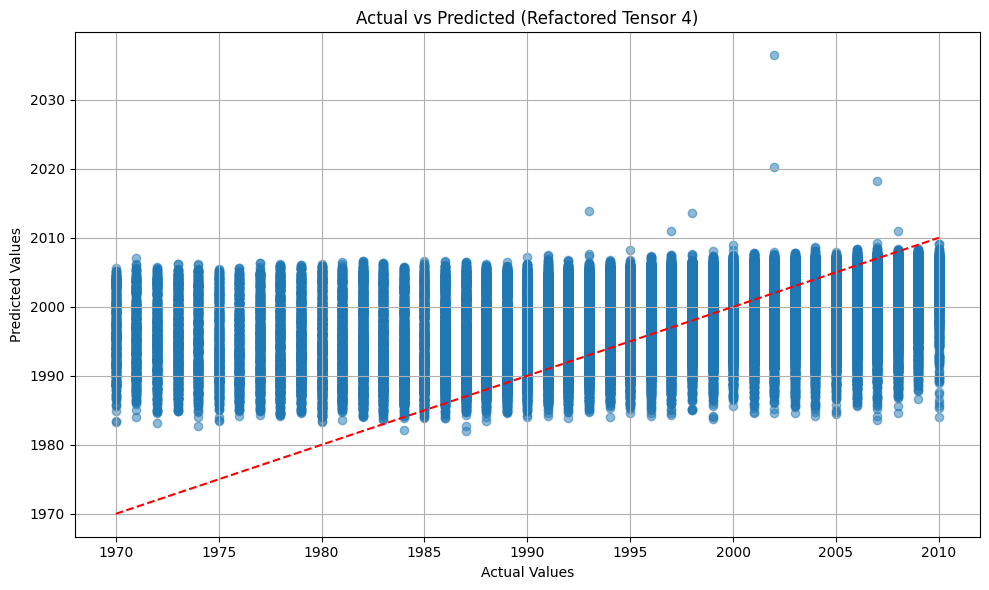

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted (Refactored Tensor 4)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Penjelasan Model Regresi

## 1. Metrik Evaluasi Model

### MSE (Mean Squared Error)
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Di mana:
- $n$ adalah jumlah sampel
- $y_i$ adalah nilai aktual
- $\hat{y}_i$ adalah nilai prediksi

MSE mengukur rata-rata kuadrat selisih antara nilai aktual dan nilai prediksi. Nilai MSE yang lebih kecil menunjukkan prediksi yang lebih baik.

### RMSE (Root Mean Squared Error)
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} = \sqrt{\text{MSE}}$$

RMSE adalah akar kuadrat dari MSE, memberikan ukuran error dalam unit yang sama dengan variabel target, yang membuatnya lebih mudah untuk diinterpretasikan.

### MAE (Mean Absolute Error)
$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

MAE mengukur rata-rata nilai absolut dari selisih antara nilai aktual dan nilai prediksi. MAE kurang sensitif terhadap outlier dibandingkan MSE.

### R² (Koefisien Determinasi)
$$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

Di mana:
- $\bar{y}$ adalah rata-rata dari nilai aktual

R² mengukur proporsi dari variansi dalam variabel dependen yang dapat diprediksi dari variabel independen. Nilai R² berkisar dari 0 hingga 1, di mana:
- R² = 1 berarti model memprediksi dengan sempurna
- R² = 0 berarti model tidak lebih baik daripada hanya memprediksi nilai rata-rata

## 2. Deteksi Outlier (IQR Method)

$$\text{IQR} = Q_3 - Q_1$$
$$\text{Lower Bound} = Q_1 - \text{multiplier} \times \text{IQR}$$
$$\text{Upper Bound} = Q_3 + \text{multiplier} \times \text{IQR}$$

Di mana:
- $Q_1$ adalah kuartil pertama (persentil ke-25)
- $Q_3$ adalah kuartil ketiga (persentil ke-75)
- multiplier adalah faktor pengali (dalam kode Anda, nilai 2.0 digunakan)

Data dianggap sebagai outlier jika nilainya kurang dari lower bound atau lebih dari upper bound.

## 3. Fungsi Aktivasi dan Komponen Neural Network

### LeakyReLU (Leaky Rectified Linear Unit)
$$f(x) =
\begin{cases}
x & \text{jika } x > 0 \\
\alpha x & \text{jika } x \leq 0
\end{cases}$$

Di mana $\alpha$ adalah parameter kecil (dalam kode Anda, $\alpha = 0.1$) yang memberikan kemiringan kecil untuk nilai negatif, mencegah masalah "dying ReLU".

### Regularisasi L2
$$L_{\text{reg}} = \lambda \sum_{w} w^2$$

Di mana:
- $\lambda$ adalah parameter regularisasi (dalam kode Anda, $\lambda = 0.0005$)
- $w$ adalah bobot model

Regularisasi L2 menambahkan penalti yang sebanding dengan kuadrat dari nilai parameter untuk mencegah overfitting.

### Huber Loss
$$L_{\delta}(y, \hat{y}) =
\begin{cases}
\frac{1}{2}(y - \hat{y})^2 & \text{untuk } |y - \hat{y}| \leq \delta \\
\delta (|y - \hat{y}| - \frac{\delta}{2}) & \text{untuk } |y - \hat{y}| > \delta
\end{cases}$$

Di mana $\delta$ adalah parameter yang mengontrol titik transisi. Huber loss menggabungkan keunggulan dari MSE dan MAE dengan menjadi kuadratik untuk residual kecil dan linier untuk residual besar, sehingga lebih robust terhadap outlier.

## 4. SHAP (SHapley Additive exPlanations)

SHAP values merupakan pendekatan dari teori permainan kooperatif untuk menjelaskan output dari model machine learning. Untuk suatu fitur $i$ dan instance $x$, SHAP value didefinisikan sebagai:

$$\phi_i(x) = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! (|N| - |S| - 1)!}{|N|!} [f_x(S \cup \{i\}) - f_x(S)]$$

Di mana:
- $N$ adalah himpunan semua fitur
- $S$ adalah subset dari fitur yang tidak mencakup fitur $i$
- $f_x(S)$ adalah nilai prediksi model ketika hanya menggunakan subset $S$ dari fitur

SHAP values mewakili kontribusi masing-masing fitur terhadap perbedaan antara prediksi aktual dan prediksi rata-rata model.

## 5. Korelasi Pearson

$$r_{xy} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \sum_{i=1}^{n} (y_i - \bar{y})^2}}$$

Di mana:
- $r_{xy}$ adalah koefisien korelasi antara variabel $x$ dan $y$
- $\bar{x}$ dan $\bar{y}$ adalah rata-rata dari variabel $x$ dan $y$

Koefisien korelasi Pearson mengukur kekuatan dan arah hubungan linear antara dua variabel. Nilainya berkisar dari -1 (korelasi negatif sempurna) hingga 1 (korelasi positif sempurna), dengan 0 menunjukkan tidak ada korelasi.